# Manifold Learning (baseline for angle recovery from estimated distances)
## Spectral Embedding

In [1]:
import os
import h5py
from sklearn.neighbors import NearestNeighbors
import numpy as np   
from matplotlib import pyplot as plt
import ipyvolume as ipv
import seaborn as sns; sns.set(style="white", color_codes=True)
from time import time
import pandas as pd

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix

import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1765503880271869692
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3799839192226189791
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16444724461376808430
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15969070399995679744
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 222756864
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 5847811206292693317
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_l

## Read generated data

Data was generated with:
```
python generator.py -mrc generated_data/bgal.mrc -num 5000
```

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
n_samples = 5000
dir_name = "../data/"
projections_filename = f"5j0n_ProjectionsAngles_ProjNber{n_samples}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

#### With Rotation Matrix

In [4]:
all_vectors = RotationMatrix(data["Angles"])

ipv.figure(width=500, height=400)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.show()

##### Angles

###### Predicted Angles

In [5]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(n_samples, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0000, 6.2830)


(5000,)

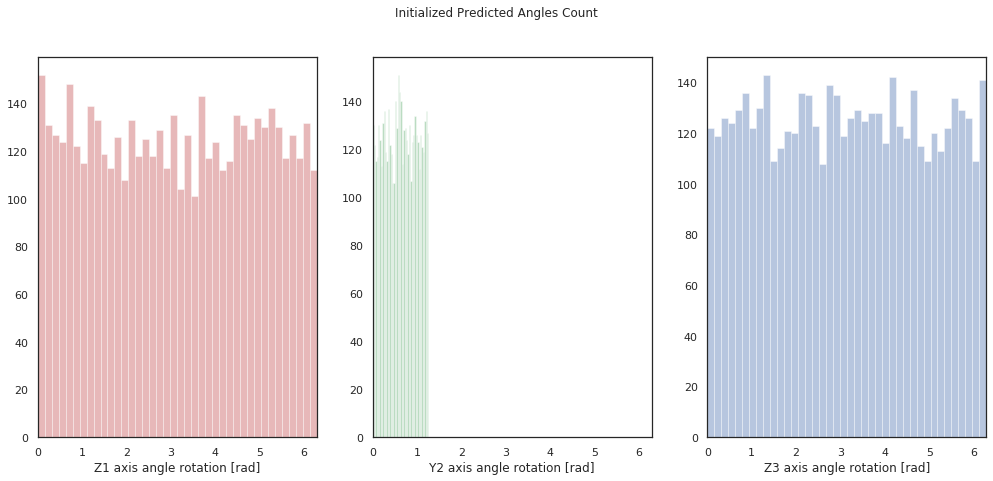

In [6]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Initialized Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

###### True Angles

In [7]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (0.0001, 6.2830)


(5000, 3)

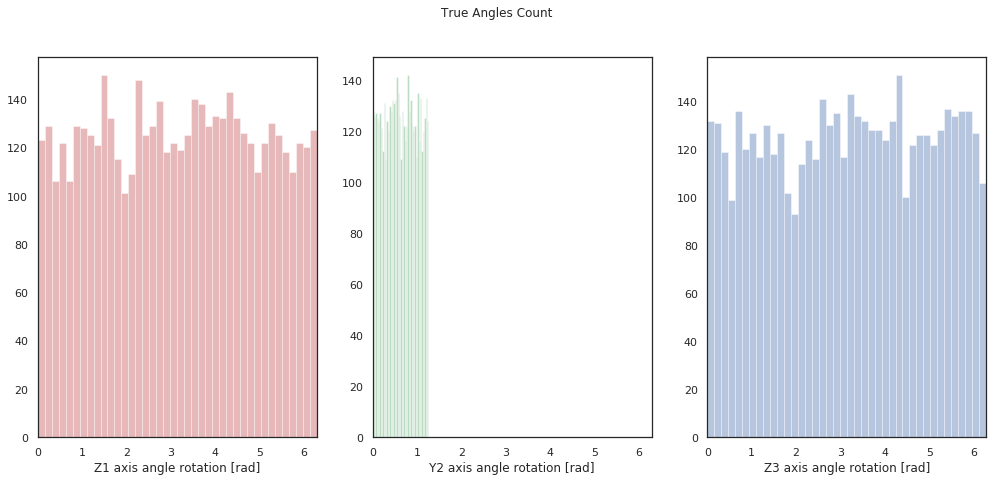

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(angles_true[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_true[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_true[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Projections

In [9]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
print(f"Projections: lenght = {len(projections)} (min, max) = ({np.min(projections):.4f}, {np.max(projections):.4f})")
projections = np.array(projections)

Projections: lenght = 5000 (min, max) = (0.0000, 15.4504)


---

## Manifold learning - Spectral Embedding

In [10]:
from sklearn.manifold import SpectralEmbedding

start_time = time()

embedding = SpectralEmbedding(n_components=4)
projections_embedding = embedding.fit_transform(projections)

print(f"--- {time() - start_time} seconds ---")

print(projections_embedding.shape)
print(projections_embedding)

np.save(f'data/SE_{projections_filename}_projections_SE', projections_embedding) 

--- 680.4886095523834 seconds ---
(5000, 4)
[[ 4.40006852e-04  5.15808789e-04  5.51518503e-04  3.74859756e-04]
 [ 1.00855911e-03 -1.57765235e-04 -1.73785242e-04 -1.06754531e-03]
 [-6.34605774e-04  3.71008503e-04 -4.16768326e-04 -5.40114690e-04]
 ...
 [ 4.59686428e-04  7.57192582e-05  5.95552495e-05  2.67566806e-04]
 [-6.39950958e-04  1.02156652e-03 -1.34998147e-03  7.17956360e-05]
 [-8.29122101e-04 -1.46959303e-04  4.04858770e-04 -8.17959063e-04]]


In [10]:
projections_embedding = np.load(f'data/SE_{projections_filename}_projections_SE.npy')

2D manifold in the result

In [11]:
ipv.figure(width=500, height=400)
ipv.scatter(projections_embedding[:, 0], projections_embedding[:, 1], projections_embedding[:, 2], marker="sphere", color="blue", size=1)
ipv.pylab.xlim(-1e-3, 1e-3)
ipv.pylab.ylim(-1e-3, 1e-3)
ipv.pylab.zlim(-1e-3, 1e-3)
ipv.show()

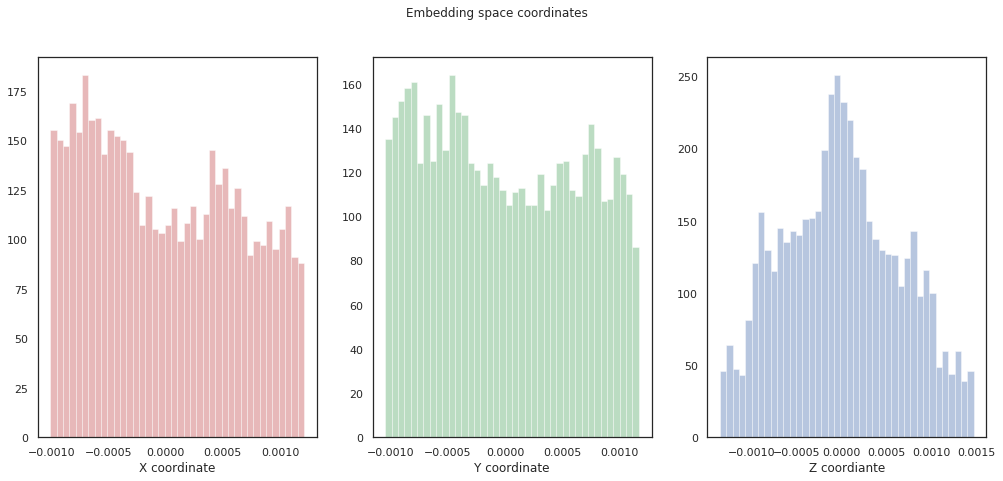

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
plt.suptitle("Embedding space coordinates")

sns.distplot(projections_embedding[:,0], kde=False, bins=40, ax=axs[0], axlabel="X coordinate", color="r")
sns.distplot(projections_embedding[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y coordinate", color="g")
sns.distplot(projections_embedding[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z coordiante", color="b");

In [17]:
# distances from (0,0,0)
# run d_P first
distances_from_center = []
for p in projections_embedding:
    distances_from_center.append(d_p(p, np.array([0,0,0,0])))


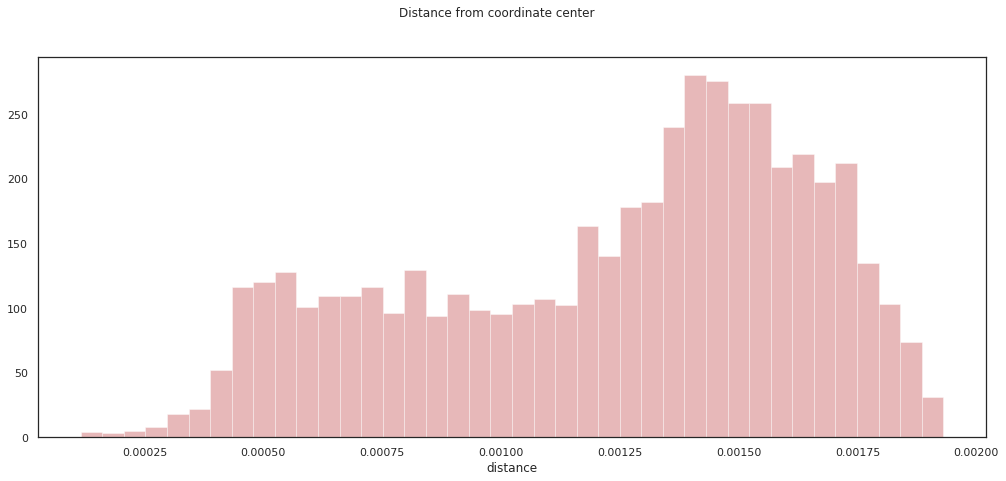

In [18]:
fig, axs = plt.subplots(1, figsize=(17,7))
plt.suptitle("Distance from coordinate center")

sns.distplot(distances_from_center, kde=False, bins=40, ax=axs, axlabel="distance", color="r");

---

## Distances

##### Angle Distances

In [22]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [23]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_true[:,0:5]), euler2quaternion(angles_true[:,0:5]))) < 1e-7

In [24]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_predicted[0:4]), euler2quaternion(angles_predicted[0:4]))) < 1e-7

In [25]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [26]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

In [27]:
assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7
assert tf.reduce_mean(d_p(projections_embedding[0:3], projections_embedding[0:3])) < 1e-7

---

## dP vs dQ

#### Slope & Intercept from 1 compared to n

Collecting data for the plot where the result shows how 1 image changes distance in comparison to all the others. 

In [28]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

d_q_list = []
d_p_list = []

# Take the first image
i = 0

# Sample some pairs.
idx1 = list([i]*5000)
idx2 = list(range(5000))

# Compute distances between quaternions
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = euler2quaternion(a1)
q2 = euler2quaternion(a2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections MDS
p1 = [projections_embedding[i] for i in idx1]
p2 = [projections_embedding[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)

Text(0, 0.5, 'd_P')

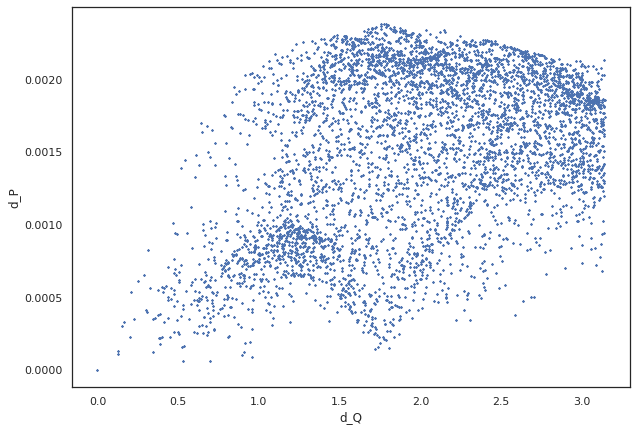

In [29]:
plt.figure(figsize=(10,7))
plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)   
plt.xlabel('d_Q')
plt.ylabel('d_P')

In [32]:
# Creating the dataframe for SNS plot
data = {"d_Q" : list(d_q_list[0].numpy()),
        "d_P" : [x for x in d_p_list[0].numpy().T[0]]}
df = pd.DataFrame(data=data)
#_df = df[df.d_Q< 0.9];

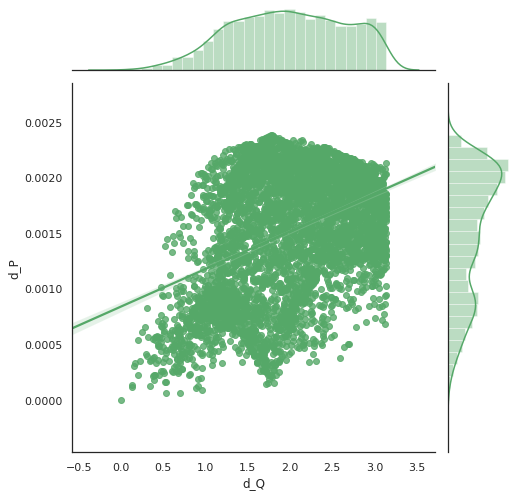

In [33]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=7)  # "reg", "kde"

In [34]:
from scipy.stats import linregress
lr = linregress(_df.d_Q, _df.d_P)
slope, intercept = lr.slope, lr.intercept
print(f"d_P/d_Q = {slope}, intercept = {intercept}")

d_P/d_Q = 0.0008498323178966203, intercept = 0.00013231649486811258


/home/jbanjac/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


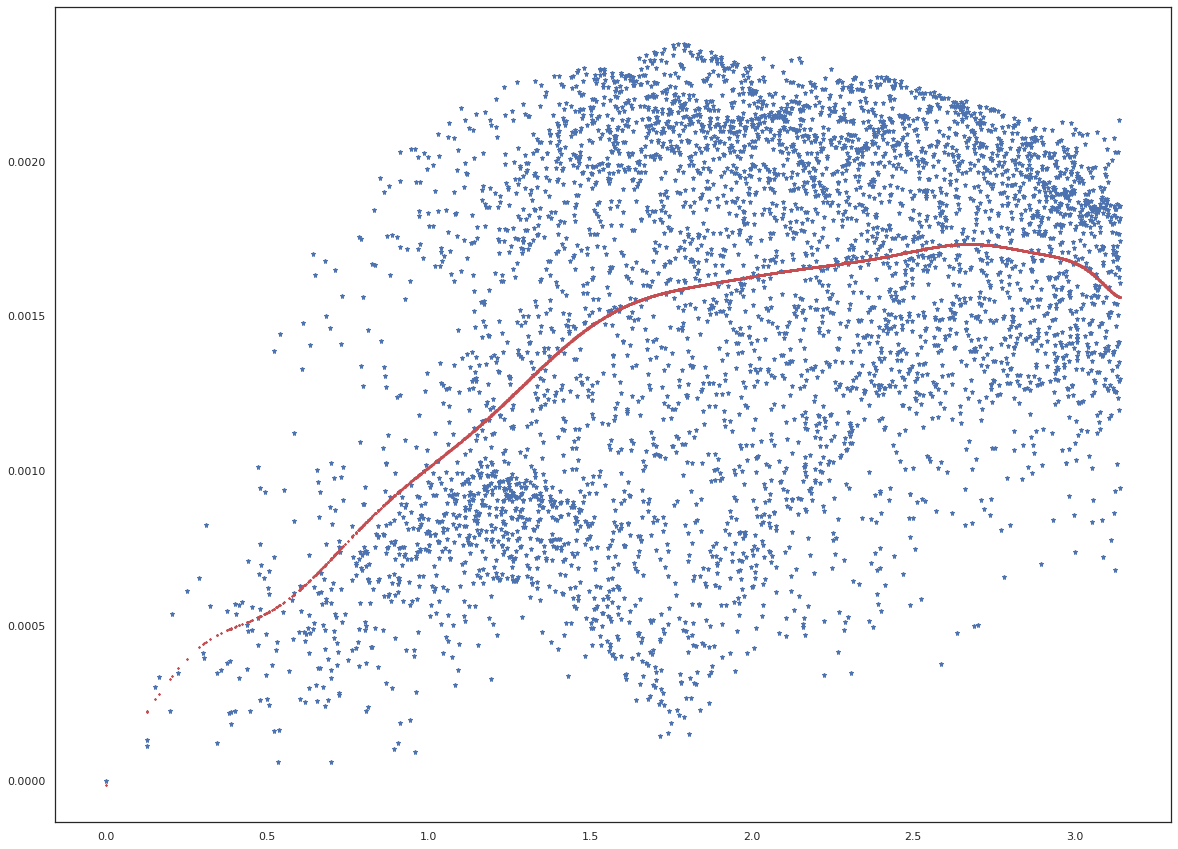

In [35]:
coeffs4dP = np.polyfit(df["d_Q"], df["d_P"], deg=16)
convert2dP = np.poly1d(coeffs4dP)

plt.figure(figsize=(20,15))
plt.plot(df["d_Q"], df["d_P"], marker="*", markersize=5, lw=0)
plt.plot(df["d_Q"], convert2dP(df["d_Q"]), marker="*", markersize=2, lw=0, c="r");

###### Slope & Intercept from m to all n

Collecting data for the plot where the result shows how several images change (m=10) distance in comparison to all the others. 

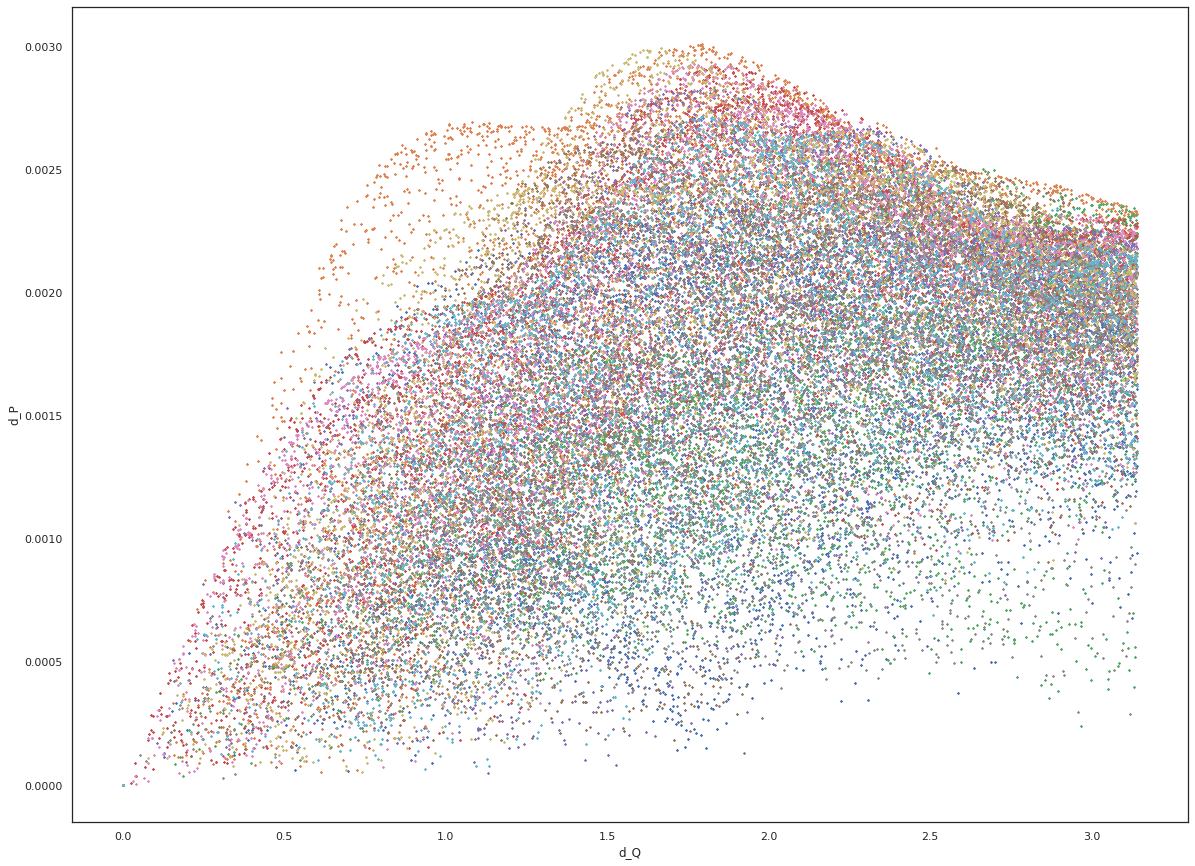

In [36]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

plt.figure(figsize=(20,15))

ITERATIONS = 5000

for i in range(0, ITERATIONS, 500):
    d_q_list = []
    d_p_list = []

    # Sample some pairs.
    idx1 = list([i]*5000)
    idx2 = list(range(5000))
    
    # Compute distances between quaternions
    a1 = [angles_true[i] for i in idx1]
    a2 = [angles_true[i] for i in idx2]
    q1 = euler2quaternion(a1)
    q2 = euler2quaternion(a2)
    distance_target_q = d_q(q1, q2)

    # Compute distances between projections
    p1 = [projections_embedding[i] for i in idx1]
    p2 = [projections_embedding[i] for i in idx2]
    distance_target_p = d_p(p1, p2)

    all_q_dist.extend([x.numpy() for x in distance_target_q])
    all_p_dist.extend([x.numpy()[0] for x in distance_target_p])
    
    plt.plot(distance_target_q, distance_target_p, marker="*", markersize=2, lw=0)
    
plt.xlabel('d_Q')
plt.ylabel('d_P');

In [37]:
# Creating the dataframe for SNS plot
data = {"d_Q" : all_q_dist,
        "d_P" : all_p_dist}
df = pd.DataFrame(data=data)

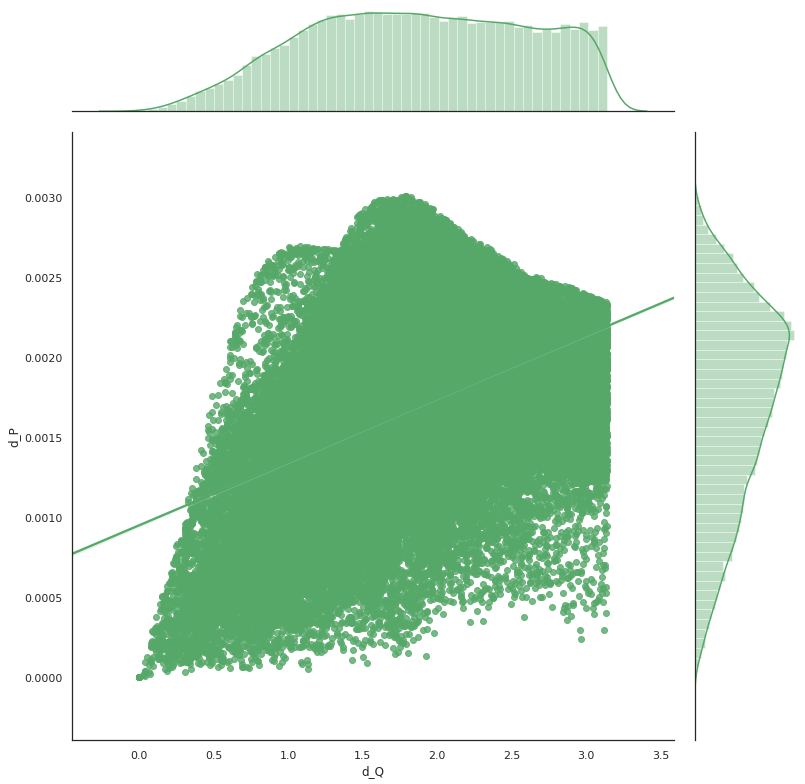

In [38]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11)  # "reg", "kde"

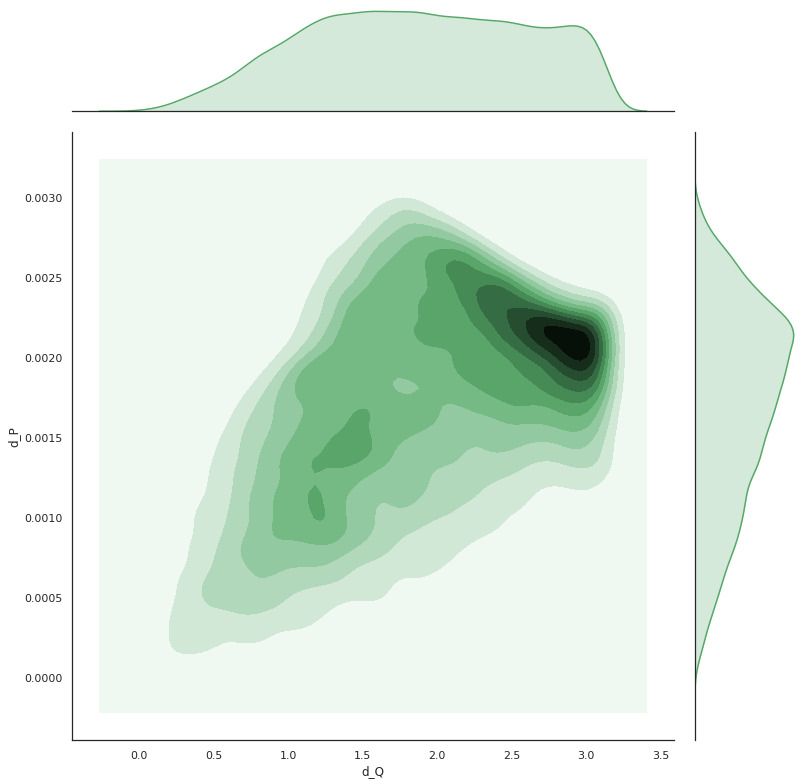

In [39]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)

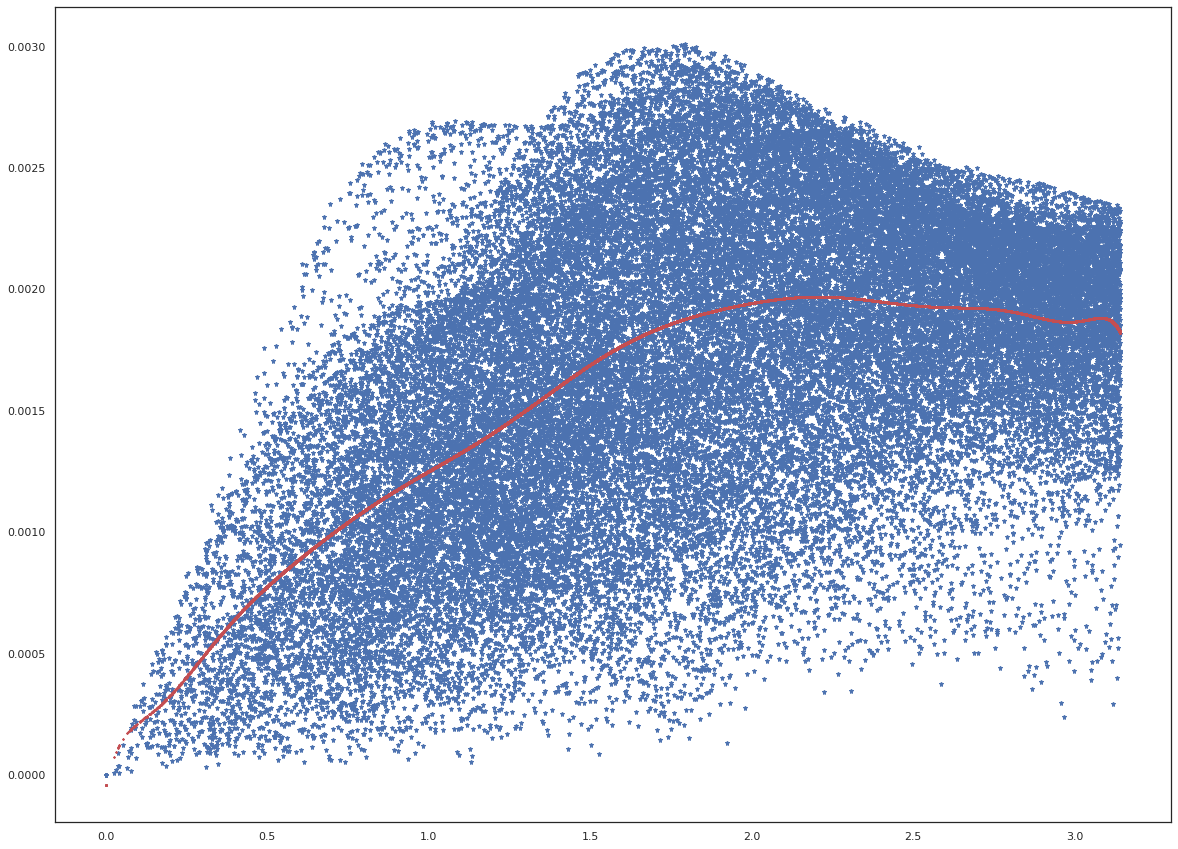

In [40]:
coeffs4dP = np.polyfit(df["d_Q"], df["d_P"], deg=14)
convert2dP = np.poly1d(coeffs4dP)

plt.figure(figsize=(20,15))
plt.plot(df["d_Q"], df["d_P"], marker="*", markersize=5, lw=0)
plt.plot(df["d_Q"], convert2dP(df["d_Q"]), marker="*", markersize=2, lw=0, c="r");

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [41]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [42]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

In [49]:
def loss_projection_vs_true_angle(steps, batch_size, optimization=False, lr=1e-3, space=None):
    if not space:
        raise Exception("Define space in which the distances will be compared!")
    
    losses = np.empty(steps)
    time_start = time()
    
    if optimization:
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")

        # Compute distances between projections
        p1 = [projections_embedding[i] for i in idx1]
        p2 = [projections_embedding[i] for i in idx2]

        distance_target = d_p(p1, p2)

        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space=space)
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dP", space=space)
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [43]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False, printing=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")
    
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [angles_true[i] for i in idx1]
        a2_true = [angles_true[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            if printing: print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')
            
    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        if printing: print(f"Mean loss: {np.mean(losses)}")
        return np.mean(losses)

In [46]:
def sample_pairs(n_samples, batch_size, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
    
    elif style=="knn":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:batch_size//2]]
        idx2_random = list(np.random.randint(0, n_samples, batch_size//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

## Optimization loop (projection-true & angles-predict)

### Compare projections and true angles

In [50]:
loss_projection_vs_true_angle(steps=2000, batch_size=256, space="dQspace")

step 200/2000 (3s): loss = 1.12e+00
step 400/2000 (6s): loss = 1.13e+00
step 600/2000 (9s): loss = 1.10e+00
step 800/2000 (12s): loss = 1.14e+00
step 1000/2000 (14s): loss = 1.07e+00
step 1200/2000 (17s): loss = 1.04e+00
step 1400/2000 (20s): loss = 1.15e+00
step 1600/2000 (23s): loss = 1.07e+00
step 1800/2000 (26s): loss = 1.05e+00
step 2000/2000 (29s): loss = 1.12e+00
Mean loss: 1.1274758707474708


In [51]:
loss_projection_vs_true_angle(steps=2000, batch_size=256, space="dPspace")

step 200/2000 (3s): loss = 5.19e-07
step 400/2000 (7s): loss = 5.47e-07
step 600/2000 (10s): loss = 5.04e-07
step 800/2000 (13s): loss = 5.62e-07
step 1000/2000 (16s): loss = 4.98e-07
step 1200/2000 (20s): loss = 5.65e-07
step 1400/2000 (23s): loss = 5.46e-07
step 1600/2000 (27s): loss = 5.73e-07
step 1800/2000 (30s): loss = 5.18e-07
step 2000/2000 (34s): loss = 5.72e-07
Mean loss: 5.490548971779364e-07


### [Before] Prediction vs. True Angles

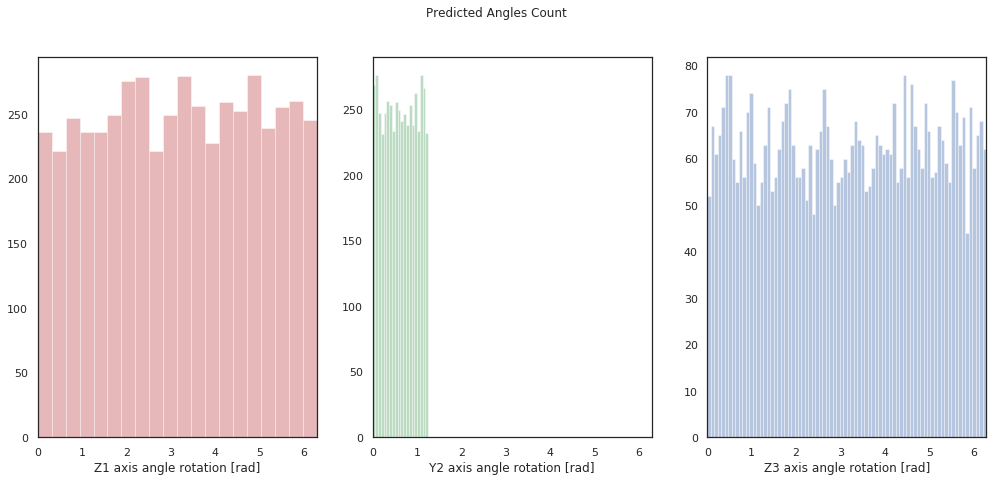

In [36]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [37]:
loss_predicted_vs_true_angle(steps=500, batch_size=256, printing=True)

step 50/500 (1s): loss = 1.04e+00
step 100/500 (1s): loss = 1.14e+00
step 150/500 (2s): loss = 1.11e+00
step 200/500 (2s): loss = 1.03e+00
step 250/500 (3s): loss = 1.24e+00
step 300/500 (4s): loss = 1.14e+00
step 350/500 (4s): loss = 1.19e+00
step 400/500 (5s): loss = 1.04e+00
step 450/500 (6s): loss = 9.65e-01
step 500/500 (6s): loss = 1.23e+00
Mean loss: 1.0853203858302511


1.0853203858302511

step 1000/10000 (99s): loss = 1.95e+00
	gt loss = 1.1234505039173468
step 2000/10000 (199s): loss = 1.88e+00
	gt loss = 1.1657660684586542
step 3000/10000 (296s): loss = 1.75e+00
	gt loss = 1.2092203573640126
step 4000/10000 (394s): loss = 1.80e+00
	gt loss = 1.2459950298384341
step 5000/10000 (492s): loss = 1.67e+00
	gt loss = 1.2733468382788984
step 6000/10000 (589s): loss = 1.52e+00
	gt loss = 1.2988252501246815
step 7000/10000 (688s): loss = 1.78e+00
	gt loss = 1.3273765960380788
step 8000/10000 (783s): loss = 1.66e+00
	gt loss = 1.3328355121379254
step 9000/10000 (881s): loss = 1.72e+00
	gt loss = 1.3529873482893202
step 10000/10000 (976s): loss = 1.61e+00
	gt loss = 1.3695530453063738


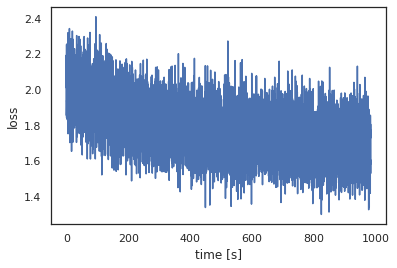

In [38]:
steps=10000
batch_size=256
lr = 0.001

loss_projection_vs_true_angle(steps=steps, batch_size=batch_size, optimization=True, lr=lr)

### [After] Prediction vs. True Angles

In [39]:
loss_predicted_vs_true_angle(steps=500, batch_size=256, printing=True)

step 50/500 (1s): loss = 1.52e+00
step 100/500 (1s): loss = 1.38e+00
step 150/500 (2s): loss = 1.39e+00
step 200/500 (3s): loss = 1.35e+00
step 250/500 (3s): loss = 1.28e+00
step 300/500 (4s): loss = 1.34e+00
step 350/500 (5s): loss = 1.23e+00
step 400/500 (5s): loss = 1.28e+00
step 450/500 (6s): loss = 1.33e+00
step 500/500 (7s): loss = 1.31e+00
Mean loss: 1.369501554431929


1.369501554431929

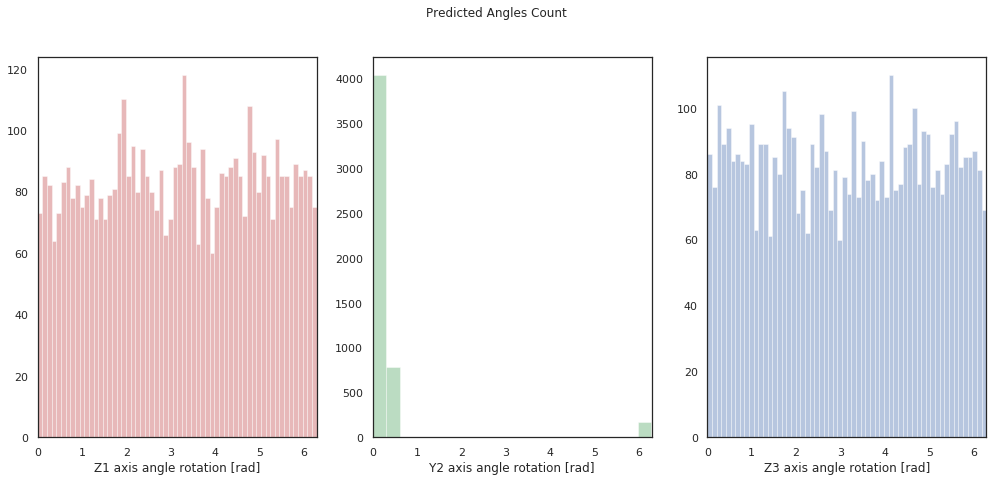

In [40]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=60, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=60, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [41]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/predicted_{lr}_{angle_ranges}.html")
ipv.show()